# Web Scraping the 2019 Michelin Restaurant Guide

The Michelin Guide is a book that is published by the tire company, Michelin. This guide details restaurants that offer the highest quality cuisine. The Michelin Guide has a rating of 1-star, 2-star, and 3-star. More stars generally means higher the quality. 

The star ratings are defined as detailed by the International Culinary Center:

- One star: The restaurant is considered very good in its category but is limited in some way. This restaurant has a quality menu and prepares cuisine to a consistently high standard, but it may lack a unique element that would bring people back over and over again.
- Two stars: The restaurant has excellent cuisine delivered in a unique way. This restaurant has something exceptional to offer and is worth a detour to visit while traveling.
- Three stars: The restaurant has exceptional cuisine and is worth a special trip just to visit. Rather than being a stop on the way to a destination, this restaurant is the destination. This restaurant serves distinct dishes that are executed to perfection.

Also, there are two other ratings within the Michelin Guide. 'Bib Gourmand' and 'The Plate MICHELIN'.

- Bib Gourmand: Exceptionally good food at moderate prices
- The Plate MICHELIN: Fresh ingredients, carefully prepared: a good meal

In [1]:
# Imports
from bs4 import BeautifulSoup
import time
from IPython.core.display import clear_output
import random
from requests import get
from warnings import warn
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# Setting base url
url = 'https://guide.michelin.com/en/restaurants/page/1'

## Understanding the HTML Structure

Before we can start web scraping, we have to understand the HTML Structure so we know how we can extract the data we want.

Using BeautifulSoup, we can easily parse the data we want.

Below, we can see classes that contain the data we want:

- Restaurants are contained in class 'col-md-6 col-lg-6 col-xl-3'
- Distinctions (Ratings) are contained in class 'fa-michelin'
- Restaurant names are contained in class 'card__menu-content--title'
- Both Cuisines and Prices are contained in 'card__menu-footer--price'

Using these classes, we can scrape each page to get the data.

In [2]:
page = get(url)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find(class_ = 'col-lg-12 search-results__column')
restaurants = results.find_all(class_ = 'col-md-6 col-lg-6 col-xl-3')
print(restaurants[0])

<div class="col-md-6 col-lg-6 col-xl-3">
<div class="card__menu js-match-height js-map" data-index="0" data-lat="37.35131" data-lng="-121.85845">
<div class="card__menu-image">
<a class="image-wrapper js-image-bg" data-position-x="50" data-position-y="50" href="/en/restaurants?region=california&amp;city=south-san-francisco">
<img alt="" class="img-fluid" src="https://d3h1lg3ksw6i6b.cloudfront.net/guide/xlarge/498398_1.jpg"/>
</a>
</div>
<div class="card__menu-content js-match-height-content">
<div class="card__menu-content--rating d-flex">
<i class="fa-michelin">‹</i>
<span>
                MICHELIN Guide 2019
            </span>
</div>
<h5 class="card__menu-content--title last">
<a href="/en/california/south-san-francisco/restaurant/adega">
                Adega
            </a>
</h5>
</div>
<div class="card__menu-footer d-flex">
<div class="card__menu-footer--location flex-fill">
<div class="icon fal fa-map-marker-alt"></div>
            South San Francisco - 95116
        </div>
<di

## Preparing the Web Scraper

Now that we know what we want to scrape. We can start the prepare the web scraper.

We know that there is 132 pages in the Michelin Guide by manually visitng the last results page. So we created a string list that we use to loop over alongside the based url.

Since we are making 132 requests to the Michelin Guide. We want to make sure that we won't make too many requests to their server too quickly. To help with this, we will use sleep the loop in random interval between 8 seconds and 15 seconds.

We also want to monitor the loop as it is going through each page. This scraper might take awhile to complete so we will monitor which number of requests we are on the speed of the request.

In [3]:
pages = [str(i) for i in range(1,208)]

In [4]:
distinctions = []
names = []
locations = []
prices = []

start_time = time.time()
requests = 0

for page in pages:
    # Make a get request
    response = get('https://guide.michelin.com/en/restaurants/page/' + page)
    
    # Pausing loop
    time.sleep(random.randint(8,15))
    
    # Monitor the requests
    requests += 1
    elapsed_time = time.time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)
    
    # Warning for non-200 status codes
    if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))
            
    # Break the loop if the number of requests is greater than expected
    if requests > 207:
        warn('Number of requests was greater than expected.')
        break
    
    # Parse the html content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Select the results container
    restaurants = soup.find_all('div', class_ = 'col-md-6 col-lg-6 col-xl-3')
    
    for restaurant in restaurants:
        # Scraping distinction
        distinction = restaurant.find(class_ = 'fa-michelin').get_text(strip = True)
        distinctions.append(distinction)
        
        # Scraping name
        name = restaurant.find(class_ = 'card__menu-content--title').get_text(strip = True)
        names.append(name)
        
        # Scraping location
        location = restaurant.find('div', class_ = 'card__menu-footer--location flex-fill').get_text(strip = True)
        locations.append(location)
        
        # Scraping price
        price = restaurant.find(class_ = 'card__menu-footer--price').get_text(strip = True)
        prices.append(price)

Request:207; Frequency: 0.07740213512590684 requests/s


In [5]:
# Creating a DataFrame
michelin_guide = pd.DataFrame(
    {
        'distinction': distinctions,
        'name': names,
        'location': locations,
        'price': prices
    })

## Inspecting the Scraped Data

Looking at the data it looks like the head and tails of the dataframe match the same restaurants on the website. We have scraped 2,628 restaurants. This number matches the number of restaunras on the website as well.

We can see that we have some cleaning to do. We will move onto that next.

In [6]:
# First 5 rows
michelin_guide.head()

,distinction,name,location,price
0,‹,Adega,South San Francisco - 95116,Portuguese\n \n ...
1,‹,Back A Yard,South San Francisco - 95113,Caribbean\n \n \...
2,=,Luna Mexican Kitchen,South San Francisco - 95101,Mexican\n \n \n ...
3,‹,Walia,South San Francisco - 95128,Ethiopian\n \n \...
4,‹,Din Tai Fung,South San Francisco - 95050,Chinese\n \n \n ...


In [7]:
# Last 5 rows
michelin_guide.tail()

,distinction,name,location,price
4116,‹,Osia,Singapore,Australian\n \n ...
4117,‹,Peony Jade (Keppel),Singapore,Cantonese\n \n \...
4118,‹,Feng Shui Inn,Singapore,Cantonese\n \n \...
4119,‹,Syun,Singapore,Japanese contemporary\n \n ...
4120,‹,Ivy's Hainanese Herbal Mutton Soup,Singapore,Street Food\n \n ...


In [8]:
# Saving DataFrame to csv
michelin_guide.to_csv('michelin_guide.csv')

In [9]:
# Reading csv file
data = pd.read_csv('michelin_guide.csv')

## Cleaning the Data

### Cleaning the Distinction Column

From looking at the HTML structure, we know that the each distinction is indicated by certain characters.

The distinctions is indicated as:
- < : The Plate MICHELIN
- = : Bib Gourmand
- m : 1 star MICHELIN
- n : 2 star MICHELIN
- o : 3 star MICHELIN

Let's get a value count to make sure we converted the the right amount of distinctions.

In [10]:
# Counting values
data['distinction'].value_counts()

‹    2750
=     753
m     488
n      96
o      34
Name: distinction, dtype: int64

In [11]:
# Creating copy of DataFrame
cleaned_distinction = data.copy()

# Replacing characters with distinction titles
cleaned_distinction = cleaned_distinction.replace(['‹', '=', 'm', 'n', 'o'],
                    ['The Plate', 'Bib Gourmand', '1-Star', '2-Star', '3-Star'])

In [12]:
# Counting clean values
cleaned_distinction['distinction'].value_counts()

The Plate       2750
Bib Gourmand     753
1-Star           488
2-Star            96
3-Star            34
Name: distinction, dtype: int64

### Cleaning the Name Column

This column should be fairly easy to clean as there shouldn't be any mispellings in the names. However we do want to see if there are any null values.

Based on the results below there are no null values.

In [13]:
# Creating copy of DataFrame
cleaned_name = cleaned_distinction.copy()

# Checking for duplicate values
n_null = cleaned_name['name'].isna().sum()
n_null

0

### Cleaning the Location Name

Some locations, like ones in the US, have additional info. We don't need information like the area code so we can remove any extra details beyond the city name.

In [14]:
# Creating copy of DataFrame
cleaned_location = cleaned_name.copy()
# Location value count
cleaned_location['location'].value_counts(dropna = False)

Singapore                       239
Hong Kong                       225
Bangkok                         171
Taipei - 110                    161
Macau                            70
Phuket                           37
New York - 10003                 35
New York - 10014                 34
Wien - 1010                      33
New York - 10013                 28
New York                         27
New York - 10012                 26
New York - 10019                 25
Chicago - 60647                  23
Washington, D.C. - 20001         22
Chicago - 60607                  21
New York - 10002                 21
Praha - 110 00                   20
Chicago - 60654                  19
New York - 10009                 18
Salzburg - 5020                  18
Washington, D.C. - 20009         18
New York - 10011                 17
City Centre - D2                 17
Chicago - 60611                  17
San Francisco - 94601            16
San Francisco - 94110            15
Washington, D.C. - 20003    

In [15]:
# Splitting string into seperate columns
location_split = cleaned_location['location'].str.split('-', expand = True)

# Replacing location values
cleaned_location['location'] = location_split[0]

In [16]:
# Cleaning white spaces
cleaned_location['location'] = cleaned_location['location'].str.strip()

In [17]:
# Location value count
cleaned_location['location'].value_counts(dropna = False)

New York                  537
San Francisco             271
Singapore                 239
Hong Kong                 225
Chicago                   199
Bangkok                   171
Taipei                    161
Washington, D.C.          126
Macau                      70
Wien                       67
København                  66
Stockholm                  48
Mayfair                    46
Soho                       37
Phuket                     37
Oslo                       35
South San Francisco        31
Praha                      31
Helsingfors / Helsinki     30
Warszawa                   27
Budapest                   26
Kraków                     25
Marylebone                 24
City Centre                21
Edinburgh                  21
Göteborg                   19
Salzburg                   19
Belfast                    19
Athína                     18
Glasgow                    16
                         ... 
Pooley Bridge               1
Buckland                    1
West Ashli

In [18]:
cleaned_location.head()

,Unnamed: 0,distinction,name,location,price
0,0,The Plate,Adega,South San Francisco,Portuguese\n \n ...
1,1,The Plate,Back A Yard,South San Francisco,Caribbean\n \n \...
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican\n \n \n ...
3,3,The Plate,Walia,South San Francisco,Ethiopian\n \n \...
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese\n \n \n ...


### Cleaning the Price Column

As we saw in the HTML code, both cuisine type and pricing distinction is in the same column. So we need split it into two different series. I try two different methods. 

1) Using series string split to get cuisine

2) Using regex to get pricing

When we get the pricing. We will see about 1,400 missing values. I initially thought this was strange so I spent some time trying different cleaning methods to see maybe I messed up a line of code. However, after cross referencing the pricing filter in the actual Michelin Guide website the value count for each value matches the website. I suspect is because Michelin Guide didn't add the pricing distinction for those restaurants. I will remove these restaurants in the the exploratory data analysis portion as I don't want to remove the data. I can revisit this project and deal with the missing data.

In [19]:
# Creating a copy of the dataframe
cleaned_price = cleaned_location.copy()
# First 5 rows
cleaned_price['price'].head()

0    Portuguese\n                \n                ...
1    Caribbean\n                \n                \...
2    Mexican\n                \n                \n ...
3    Ethiopian\n                \n                \...
4    Chinese\n                \n                \n ...
Name: price, dtype: object

In [20]:
# Stripping the strings into seperate series
price_split = cleaned_price['price'].str.split('\n', expand = True)

In [21]:
# Saving the cuisine into a new series
cleaned_price['cuisine'] = price_split[0]
# Saving the pricing into a new series
cleaned_price['pricing'] = cleaned_price['price'].str.replace('[^$]', '')

In [22]:
# Dropping the original price series
cleaned_price.drop(columns = ['price'], inplace = True)

In [23]:
# Value count of pricing series
cleaned_price['pricing'].value_counts(dropna = False)

         1497
$$        979
$         728
$$$       438
$$$$      337
$$$$$     142
Name: pricing, dtype: int64

In [24]:
# Cleaning extra characters
cleaned_price['pricing'] = cleaned_price['pricing'].str.replace('·', '')
#Cleaning white spaces
cleaned_price['pricing'] = cleaned_price['pricing'].str.strip()

In [25]:
# Value count of pricing series
cleaned_price['pricing'].value_counts()

         1497
$$        979
$         728
$$$       438
$$$$      337
$$$$$     142
Name: pricing, dtype: int64

### Cleaning the Cuisine Column

Here we are removing the extra characters and white spaces from each value.

In [26]:
# Creating a copy of the dataframe
cleaned_cuisine = cleaned_price.copy()

In [27]:
# Cleaning extra characters
cleaned_cuisine['cuisine'] = cleaned_cuisine['cuisine'].str.replace('·', '')
# Cleaning white spaces
cleaned_cuisine['cuisine'] = cleaned_cuisine['cuisine'].str.strip()

### Cleaning the Pricing Column

Here I am changing the dollar sign character to numerical to make our exploratory data analysis portion easier.

In [28]:
# Creating a copy of the dataframe
cleaned_pricing = cleaned_cuisine.copy()

In [29]:
# Count of pricing distinctions
cleaned_pricing['pricing'].value_counts(dropna = False)

         1497
$$        979
$         728
$$$       438
$$$$      337
$$$$$     142
Name: pricing, dtype: int64

In [30]:
# Cleaning white spaces
cleaned_pricing['pricing'] = cleaned_pricing['pricing'].str.strip()

In [31]:
# Changing dollar signs to numerical values
cleaned_pricing['pricing'] = cleaned_pricing['pricing'].replace(['$', '$$', '$$$', '$$$$', '$$$$$'], ['1', '2', '3', '4', '5'])

In [32]:
# Count of pricing distinctions
cleaned_pricing['pricing'].value_counts(dropna = False)

     1497
2     979
1     728
3     438
4     337
5     142
Name: pricing, dtype: int64

In [33]:
# Renaming series
cleaned_pricing.rename(columns = {'pricing': 'pricing (by $)'})

,Unnamed: 0,distinction,name,location,cuisine,pricing (by $)
0,0,The Plate,Adega,South San Francisco,Portuguese,3
1,1,The Plate,Back A Yard,South San Francisco,Caribbean,1
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican,2
3,3,The Plate,Walia,South San Francisco,Ethiopian,1
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese,2
5,5,The Plate,Jang Su Jang,South San Francisco,Korean,2
6,6,The Plate,Sawa Sushi,South San Francisco,Japanese,4
7,7,The Plate,Thiên Long,South San Francisco,Vietnamese,1
8,8,The Plate,Lau Hai San,South San Francisco,Vietnamese,2
9,9,The Plate,DishDash,South San Francisco,Middle Eastern,2


In [34]:
# First 5 rows
cleaned_pricing.head()

,Unnamed: 0,distinction,name,location,cuisine,pricing
0,0,The Plate,Adega,South San Francisco,Portuguese,3
1,1,The Plate,Back A Yard,South San Francisco,Caribbean,1
2,2,Bib Gourmand,Luna Mexican Kitchen,South San Francisco,Mexican,2
3,3,The Plate,Walia,South San Francisco,Ethiopian,1
4,4,The Plate,Din Tai Fung,South San Francisco,Chinese,2


### Saving the Cleaned Data to csv

We cleaned most of the data. Let's save it for now and come back to it in the exploratory data analysis section.

In [35]:
# Saving dataframe to csv
cleaned_pricing.to_csv('cleaned_michelin_guide.csv')

## Basic Exploratory Data Analysis

#### Description of Distinction:
- One star: The restaurant is considered very good in its category but is limited in some way. This restaurant has a quality menu and prepares cuisine to a consistently high standard, but it may lack a unique element that would bring people back over and over again.
- Two stars: The restaurant has excellent cuisine delivered in a unique way. This restaurant has something exceptional to offer and is worth a detour to visit while traveling.
- Three stars: The restaurant has exceptional cuisine and is worth a special trip just to visit. Rather than being a stop on the way to a destination, this restaurant is the destination. This restaurant serves distinct dishes that are executed to perfection.
- Bib Gourmand: Exceptionally good food at moderate prices
- The Plate MICHELIN: Fresh ingredients, carefully prepared: a good meal

#### Description of Pricing:
- 1: Under 25 USD
- 2: 25 - 50 USD
- 3: 50 - 75 USD
- 4: Over 75 USD
- 5: Over 100 USD

In [37]:
# Reading the csv file
data = pd.read_csv('cleaned_michelin_guide.csv')
# Pandas Profiling
pandas_profiling.ProfileReport(data)

Number of variables,7
Number of observations,4121
Total Missing (%),5.2%
Total size in memory,225.4 KiB
Average record size in memory,56.0 B
Numeric,2
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,1


### Additional Cleaning

Removing the extra columns the the null values I mentioned during the data cleaning process.

In [38]:
# Dropping extra columns and null values
data = data.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1']).dropna()

### Which Cuisine Appeared the Most Overall?

- Street Food appears the most with over 200 restaurants
- Italian appears the second most with over 200 restaurants as well

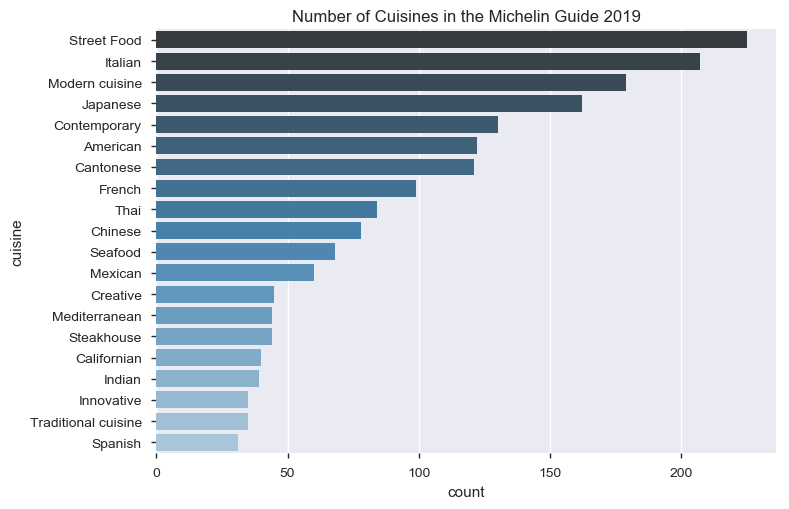

In [39]:
# Countplot of cuisines
ax = sns.countplot(y = 'cuisine', data = data, order = data['cuisine'].value_counts()[:20].index, palette = 'Blues_d').set_title('Number of Cuisines in the Michelin Guide 2019')

### Which Location Appeared the Most Overall?

- New York appears more often by a large margin with over 500 restaurants.
- San Francisco appeared the second most often with over 250 restaurants.

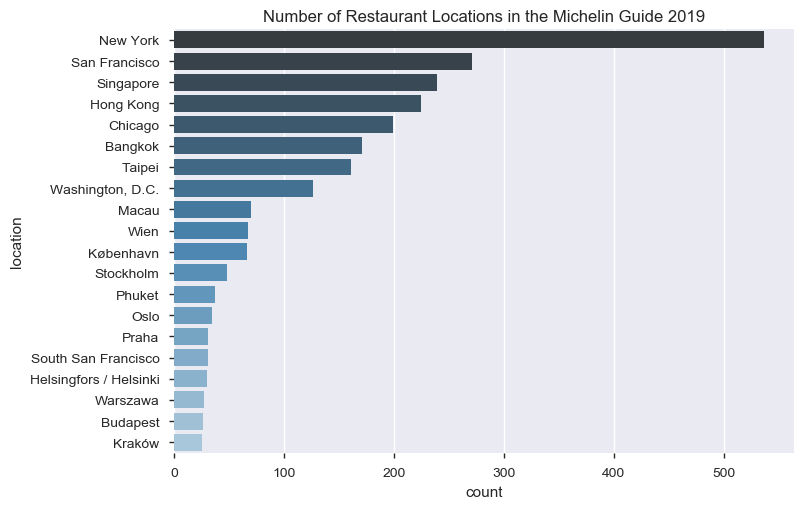

In [40]:
# Countplot of locations
ax = sns.countplot(y = 'location', data = data, order = data['location'].value_counts()[:20].index, palette = 'Blues_d').set_title('Number of Restaurant Locations in the Michelin Guide 2019')

### What is the Count of each Distinction?

- The Plate has over 1,500 restaurants in the Michelin Guide. This makes sense though since the requirements for The Plate vs Michelin Stars are lower.
- Conversly, 3-Star restaurants have very few.

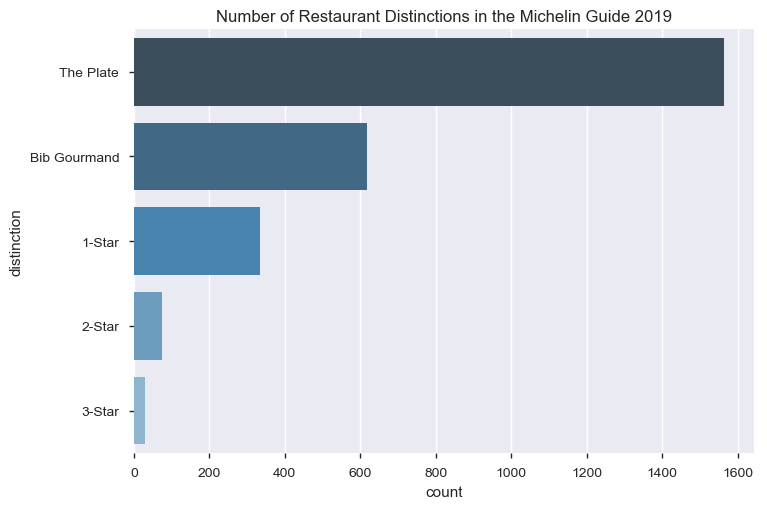

In [41]:
# Countplot of distinctions
ax = sns.countplot(y = 'distinction', data = data, order = data['distinction'].value_counts().index, palette = 'Blues_d').set_title('Number of Restaurant Distinctions in the Michelin Guide 2019')

### Which Cuisine has the Most 1-Star Michelin?

- The top two cuisines for 1-Star Michelin restaurants are 'Modern Cuisine' and 'Contemporary'. Since Michelin stars are moving towards more fine dining. This would make sense why 'Modern Cuisine' and 'Contemporary are more common in the 1-Star distinction.
- The next two cuisines for 1-Star Michelin restaurants are 'Cantonese' and 'Japanese'. There are probably more traditional cuisine but elevated to be more fine dining.

In [42]:
# Filter data by 1-Star Michelin
star_1 = data[data['distinction'] == '1-Star']

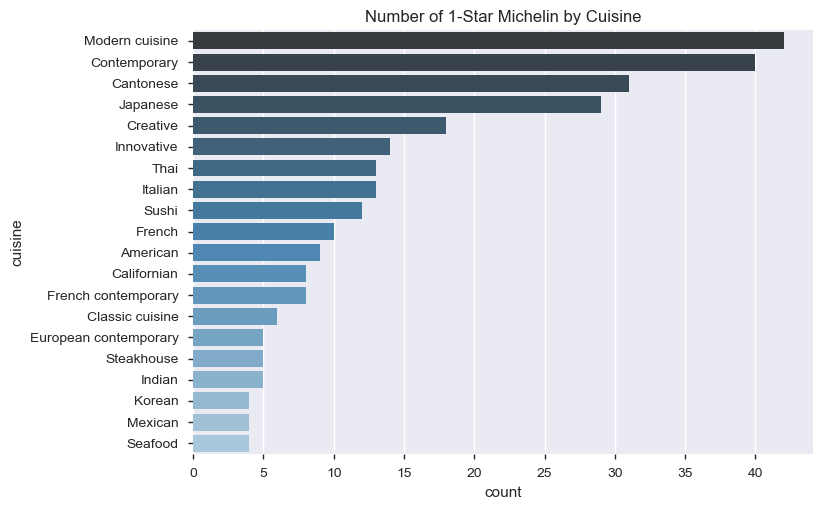

In [43]:
# Countplot of 1-Star Michelin
ax = sns.countplot(y = 'cuisine', data = star_1, order = star_1['cuisine'].value_counts()[:20].index, palette = 'Blues_d').set_title('Number of 1-Star Michelin by Cuisine')

### Which Cuisine has the Most 2-Star Michelin?

- The top two cuisines for 2-Star restaurants are 'Contemporary' and 'Creative'. Just like 1-star Michelin restaurants these makes sense as the most common cuisines for fine dining.
- Comparing between 1-star Michelin restaurants, 'Cantonese' and 'Japanese' has droped from their spot and replaced by 'French Contemporary' and 'Modern Cuisine' both of which would are more fine dining cuisines.
- 'Modern Cuisine' has dropped down to third most 2-Star Michelin restaurants

In [44]:
# Filter data by 2-Star Michelin
star_2 = data[data['distinction'] == '2-Star']

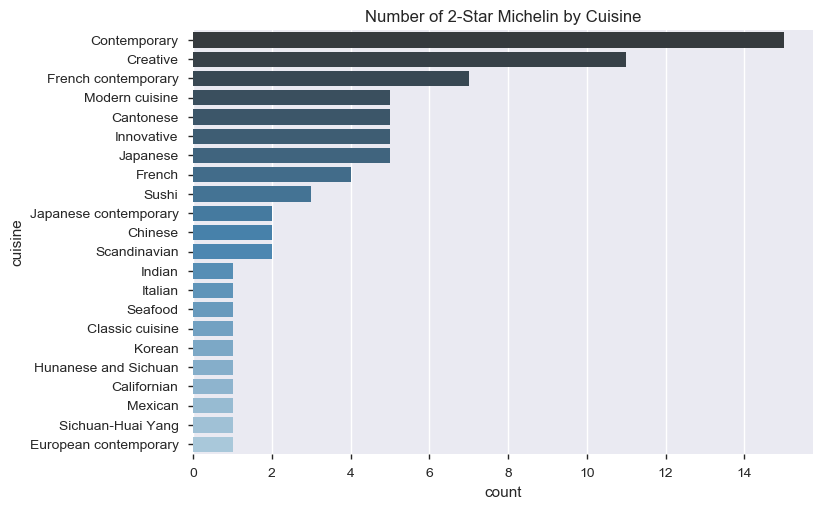

In [45]:
# Countplot of 2-Star Michelin
ax = sns.countplot(y = 'cuisine', data = star_2, order = star_2['cuisine'].value_counts().index, palette = 'Blues_d').set_title('Number of 2-Star Michelin by Cuisine')

### Which Cuisine has the Most 3-Star Michelin?

- 'Contemporary' is the most common 3-Star Michelin Cuisine with 10 restaurants.
- Suprisingly, 'Cantonese' has the second most common 3-Star Michelin. I would have suspected 'Creative' or 'Innovative' to be take the spot.

In [46]:
#Filter by 3-Star Michelin
star_3 = data[data['distinction'] == '3-Star']

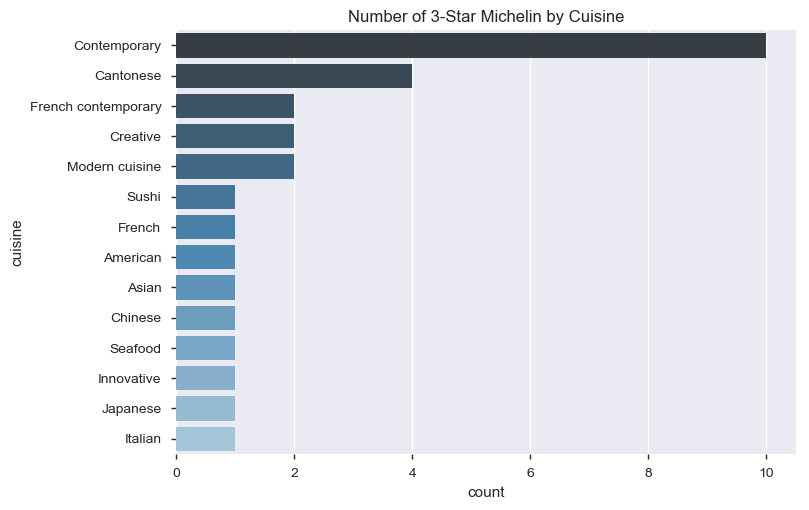

In [47]:
# Countplot of 3-Star Michelin
ax = sns.countplot(y = 'cuisine', data = star_3, order = star_3['cuisine'].value_counts().index, palette = 'Blues_d').set_title('Number of 3-Star Michelin by Cuisine')

### Which Location has the Most 1-Star Michelin?

- New York has the most 1-Star Michelin restaurants
- Hong Kong has the second most 1-Star Michelin restaurants
- San Francisco has the the third most 3-Star Michelin restaurants

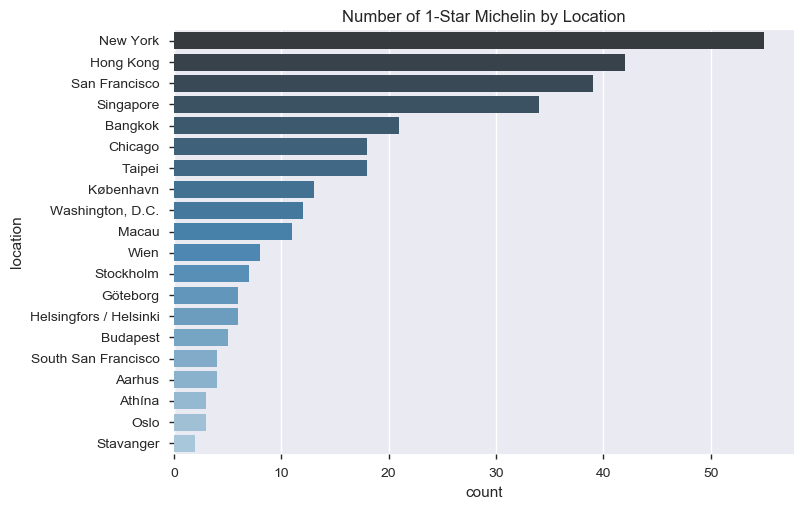

In [48]:
# Countplot of 1-Star Michelin by location
ax = sns.countplot(y = 'location', data = star_1, order = star_1['location'].value_counts()[:20].index, palette = 'Blues_d').set_title('Number of 1-Star Michelin by Location')

### Which  Location has the Most 2-Star Michelin?

Just like the 1-Star Michelin restaurants.

- New York has the most 1-Star Michelin restaurants
- Hong Kong has the second most 1-Star Michelin restaurants
- San Francisco has the the third most 3-Star Michelin restaurants

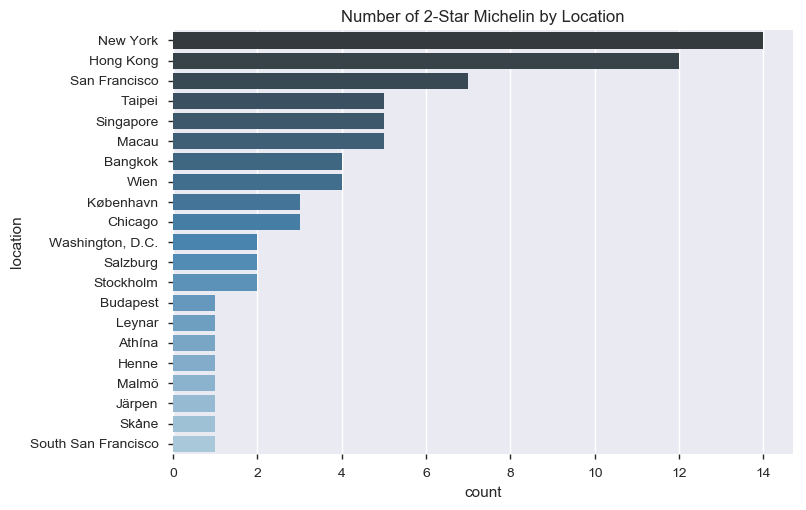

In [49]:
# Countplot of 2-Star Michelin by Location
ax = sns.countplot(y = 'location', data = star_2, order = star_2['location'].value_counts().index, palette = 'Blues_d').set_title('Number of 2-Star Michelin by Location')

### Which Location has the Most 3-Star Michelin?

- Hong Kong has the most 3-Star Michelin restaurants
- New York dropped to having the third most 3-Star Michelin restaurants

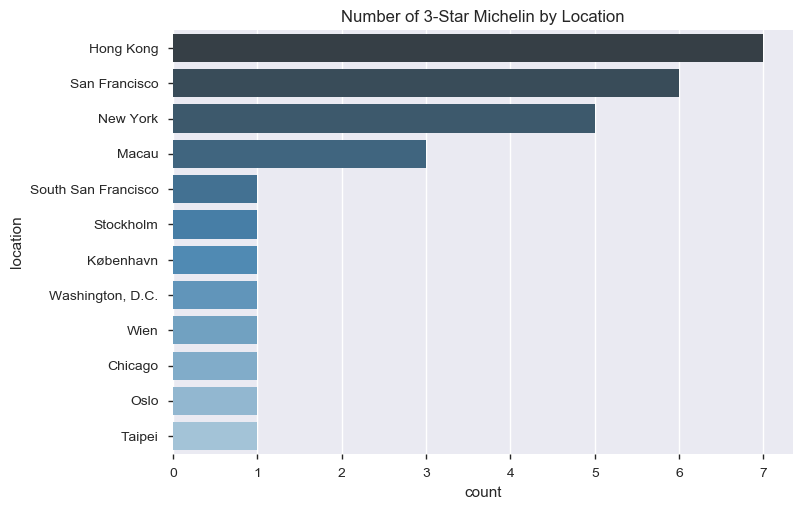

In [50]:
# Countplot of 3-Star Michelin by location
ax = sns.countplot(y = 'location', data = star_3, order = star_3['location'].value_counts().index, palette = 'Blues_d').set_title('Number of 3-Star Michelin by Location')

### Which Location has the Most Michelin Stars Overall?

- Since this is a sum of the previous three plots. New York, Hong Kong, and San Francisco still hold the top three spots.

In [51]:
# Filter data by all Michelin Stars
michelin_stars = data[(data['distinction'] != 'The Plate') & (data['distinction'] != 'Bib Gourmand')]

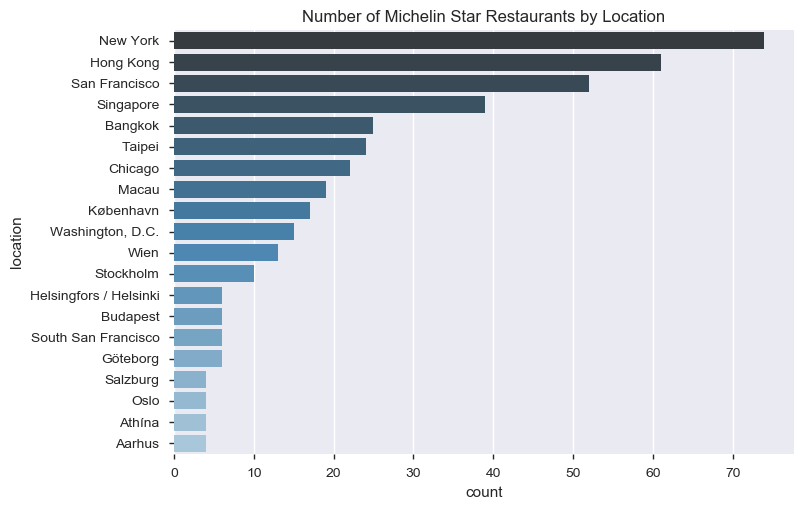

In [52]:
# Countplot of all Michelin Stars by location
ax = sns.countplot(y = 'location', data = michelin_stars, order = michelin_stars['location'].value_counts().index[:20], palette = 'Blues_d').set_title('Number of Michelin Star Restaurants by Location')

### What Type of Cuisines Appear in the Cities with the Most Michelin Stars?

In [53]:
# Filter New York Michelin Stars
ny_michelin_stars = michelin_stars[michelin_stars['location'] == 'New York']

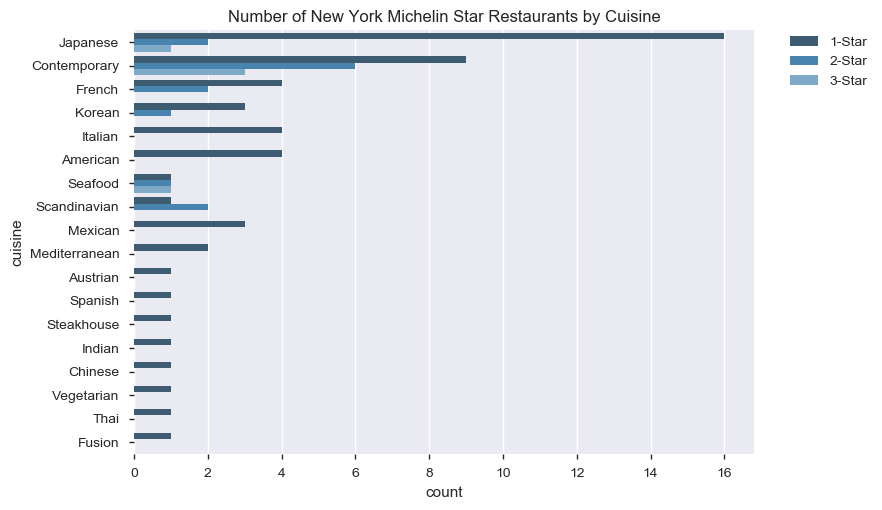

In [54]:
# Countplot of New York Michelin Stars by cuisine
ax = sns.countplot(y = 'cuisine', data = ny_michelin_stars, order = ny_michelin_stars['cuisine'].value_counts().index, palette = 'Blues_d', hue  = 'distinction').set_title('Number of New York Michelin Star Restaurants by Cuisine')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Japanese Cuisine has the most overall Michelin Star restaurants in New York with sixteen 1-Star, two 2-Star, and one 3-Star. A total of 19 restaurants.
- Contemporary is tied with Japanese with the most overall Michelin Star restauraunts with ten 1-Star, six 2-Star, and three 3-Star. A total of 19 restauarants.

In [55]:
# Filter Hong Kong Michelin Stars
hk_michelin_stars = michelin_stars[michelin_stars['location'] == 'Hong Kong']

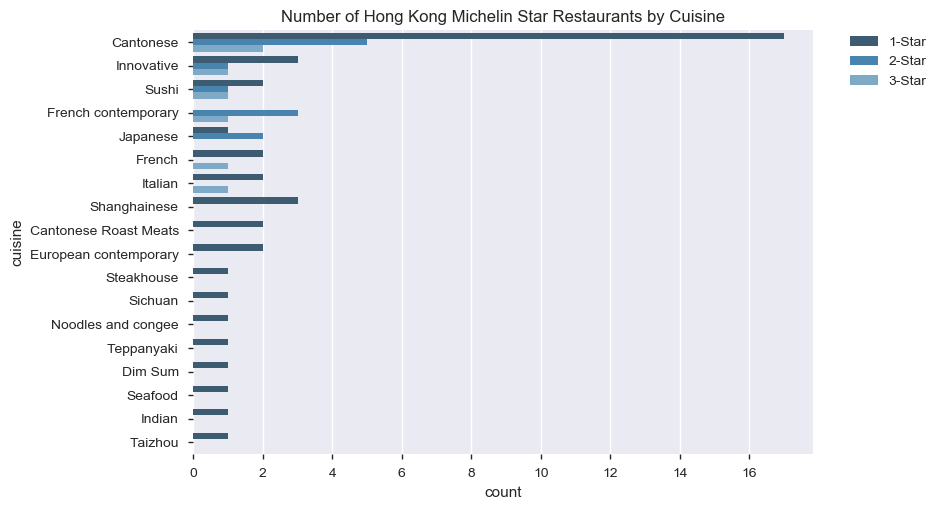

In [56]:
# Countplot of Hong Kong Michelin Stars by cuisine
ax = sns.countplot(y = 'cuisine', data = hk_michelin_stars, order = hk_michelin_stars['cuisine'].value_counts().index, palette = 'Blues_d', hue = 'distinction').set_title('Number of Hong Kong Michelin Star Restaurants by Cuisine')
# Move legend out of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cantonese has the most Michelin Star restaurants with seventeen 1-Star, five 2-Star, and two 3-Star. A total of 24 restaurants.
- Innovative has the second most Michelin Star restaurants with four 1-Star, one 2-Star, and one 3-Star. A total of 6 restaurants.

In [57]:
# Filter San Francisco Michelin Stars
sf_michelin_stars = michelin_stars[michelin_stars['location'] == 'San Francisco']

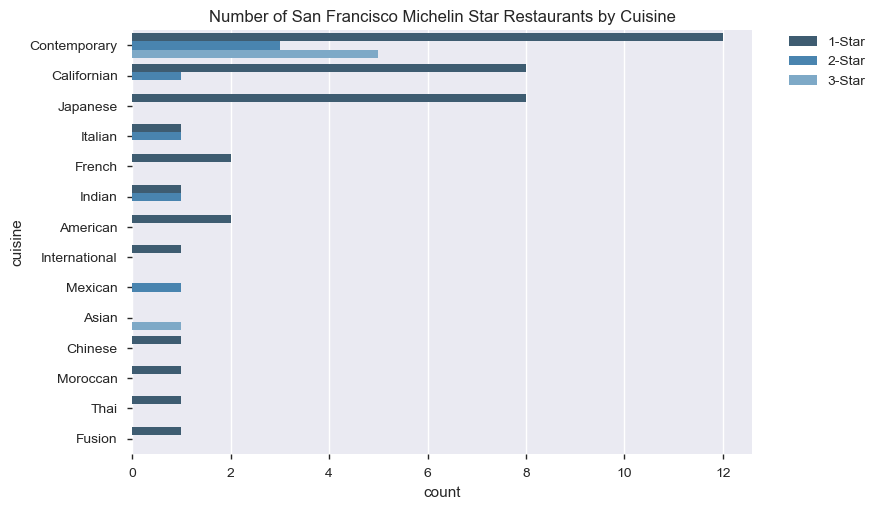

In [58]:
# Countplot of San Francisco Michelin Stars by cuisine
ax = sns.countplot(y = 'cuisine', data = sf_michelin_stars, order = sf_michelin_stars['cuisine'].value_counts().index, palette = 'Blues_d', hue = 'distinction').set_title('Number of San Francisco Michelin Star Restaurants by Cuisine')
# Move legend out of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Contemporary has the most Michelin Star restaurants with twelve 1-Star, three 2-Star, and five 3-Star. A total of 20 restaurants.
- Californian has the second most Michelin Star restaurants with eight 1-Star, one 2-Star, and zero 3-Star. A total of of 9 restaurants.
- The only other cuisine with 3-Star is Asian cuisine.

### What Pricing do Michelin Star Restaurants Fall Under?

- Most 1-Star restaurants pricing start from 50 USD to over 75 USD.
- Most 2-Star restaurants pricing are over 75 USD.
- Most 3-Star restaurants pricing are over 75 USD.

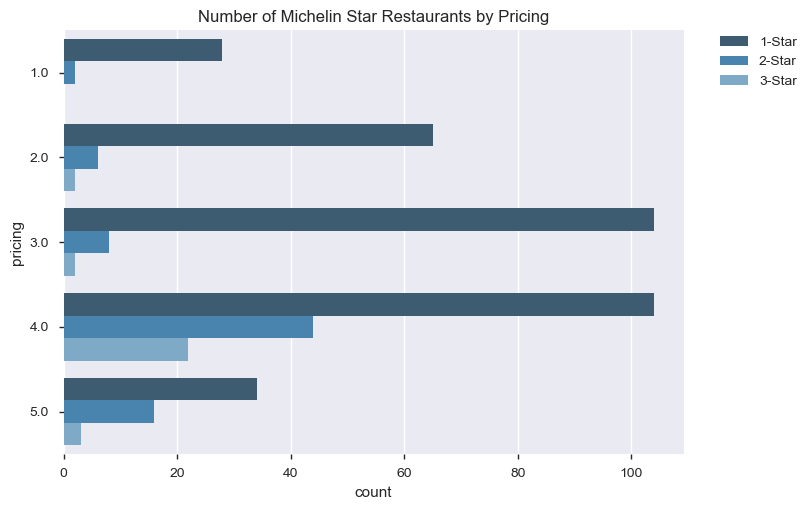

In [59]:
# Countplot of all Michelin Stars by pricing
ax = sns.countplot(y = 'pricing', data = michelin_stars, palette = 'Blues_d', hue = 'distinction').set_title('Number of Michelin Star Restaurants by Pricing')
# Move legend out of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Conclusion

The main goal of this project was to try my hand at web scraping and I figured web scraping the 2019 Michelin Guide would be interesting to look at. We looked at the different types of cuisines, the locations of restaurants, and their pricing structure. If I wanted to go on a Michelin guided restaurant tour, the best place to go is New York. New York having the most Michelin Star restaurants as well as a guide variety of cuisines.

I can revisit this to include the restaurants that did not have the pricing distinction once the Michelin Guide has updated their website with each restaurant's price distinction.